# Set up Env

In [ ]:
!pip install tensorflow_addons
!pip install transformers
!pip install sentencepiece
!pip install torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Prepare Workspace

In [ ]:
import glob
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import History 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification

import pickle
from tqdm import trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

In [ ]:
# Global vars
AUDIO_MODEL_DIR = 'drive/MyDrive/HushUp/EmotionDetection/Models'
EMOTION_LABELS = 'drive/MyDrive/HushUp/EmotionDetection/Emotion_Labels_final.csv'
AUDIO_FEATURE_FILE = 'drive/MyDrive/HushUp/EmotionDetection/pyaud_iemocap_long_features.csv'

tokenizer_model_name = 'bert-base-uncased'  # 'albert-base-v2', 'albert-large-v2'
TEXT_MODEL_DIR = "drive/MyDrive/HushUp/OffensiveTextClassifier/Models/BERT_5"
TEXT_DATA_FILE = 'drive/MyDrive/HushUp/OffensiveTextClassifier/compiled_data.csv'
WORKSPACE = 'drive/MyDrive/HushUp/MML_Models'

In [ ]:
emotion_labels_df = pd.read_csv(EMOTION_LABELS, usecols=['Filename', 'Valence', 'Arousal', 'Dominance'])
emotion_labels_df.rename(columns={'Filename': 'file_name', 'Valence': 'valence', 'Arousal': 'arousal', 'Dominance': 'dominance'}, inplace=True)
print(emotion_labels_df.shape)
print(emotion_labels_df.head())

audio_feature_df = pd.read_csv(AUDIO_FEATURE_FILE)
audio_feature_df['file_name'] = audio_feature_df.apply(lambda x: x['file_name'].split('.')[0], axis=1)

columns = ['file_name']
for i in range(1360):
  columns.append('aud_f_'+str(i))

audio_feature_df = pd.read_csv(AUDIO_FEATURE_FILE, names=columns)
audio_feature_df['file_name'] = audio_feature_df.apply(lambda x: x['file_name'].split('.')[0], axis=1)
print(audio_feature_df.shape)
print(audio_feature_df.head())

(499, 4)
  file_name  valence  arousal  dominance
0   1_00001      3.0      2.5        2.5
1   1_00002      2.0      2.5        3.5
2   1_00003      2.0      3.0        2.5
3   1_00004      2.5      2.5        2.5
4   1_00005      2.5      2.5        2.5
(499, 1361)
  file_name   aud_f_0   aud_f_1  ...  aud_f_1357  aud_f_1358  aud_f_1359
0   0_00001  0.110322  0.018521  ...    0.036982    0.019467    0.026433
1   0_00002  0.084097  0.011105  ...    0.068084    0.032504    0.018131
2   0_00003  0.038838  0.006549  ...    0.057489    0.032149    0.014548
3   0_00004  0.059120  0.019254  ...    0.053626    0.021431    0.033176
4   0_00005  0.070304  0.012774  ...    0.030095    0.018690    0.014640

[5 rows x 1361 columns]


In [ ]:
text_df = pd.read_csv(TEXT_DATA_FILE)
text_df = text_df[['Filename', 'Text', 'Label']]
text_df.rename(columns={'Filename': 'file_name'}, inplace=True)
print(text_df.shape)
print(text_df.head())

(499, 3)
  file_name                                               Text  Label
0   1_00001      Do jews wear those hats to cover their horns?      1
1   1_00002                         Why do hindus look smelly.      1
2   1_00003  Christian freaks are terrifying, they scare me...      1
3   1_00004  Most aethists are effing liberals and they are...      1
4   1_00005  Arguing with muslims is like playing chess wit...      1


In [ ]:
master_df = pd.merge(emotion_labels_df, audio_feature_df, on='file_name')
master_df = pd.merge(text_df, master_df, on='file_name')

# Scaling attributes between 0 and 1
master_df['arousal'] = master_df.apply(lambda x: float(x['arousal'])/5,axis=1)
master_df['valence'] = master_df.apply(lambda x: float(x['valence'])/5,axis=1)
master_df['dominance'] = master_df.apply(lambda x: float(x['dominance'])/5,axis=1)

print(master_df.shape)
master_df.head()

(499, 1366)


,file_name,Text,Label,valence,arousal,dominance,aud_f_0,aud_f_1,aud_f_2,aud_f_3,aud_f_4,aud_f_5,aud_f_6,aud_f_7,aud_f_8,aud_f_9,aud_f_10,aud_f_11,aud_f_12,aud_f_13,aud_f_14,aud_f_15,aud_f_16,aud_f_17,aud_f_18,aud_f_19,aud_f_20,aud_f_21,aud_f_22,aud_f_23,aud_f_24,aud_f_25,aud_f_26,aud_f_27,aud_f_28,aud_f_29,aud_f_30,aud_f_31,aud_f_32,aud_f_33,...,aud_f_1320,aud_f_1321,aud_f_1322,aud_f_1323,aud_f_1324,aud_f_1325,aud_f_1326,aud_f_1327,aud_f_1328,aud_f_1329,aud_f_1330,aud_f_1331,aud_f_1332,aud_f_1333,aud_f_1334,aud_f_1335,aud_f_1336,aud_f_1337,aud_f_1338,aud_f_1339,aud_f_1340,aud_f_1341,aud_f_1342,aud_f_1343,aud_f_1344,aud_f_1345,aud_f_1346,aud_f_1347,aud_f_1348,aud_f_1349,aud_f_1350,aud_f_1351,aud_f_1352,aud_f_1353,aud_f_1354,aud_f_1355,aud_f_1356,aud_f_1357,aud_f_1358,aud_f_1359
0,1_00001,Do jews wear those hats to cover their horns?,1,0.6,0.5,0.5,0.053376,0.015420,2.970222,0.122785,0.155951,0.438711,0.063522,0.089208,-36.635069,1.962763,0.766618,0.058921,-0.358748,-0.066035,-0.279175,-0.142601,-0.004379,0.035246,0.094478,0.100166,-0.157845,0.009878,0.002744,0.028361,0.008019,0.039752,0.012379,0.037249,0.001031,0.020246,0.012831,0.015710,0.004051,0.028511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1_00002,Why do hindus look smelly.,1,0.4,0.5,0.7,0.049312,0.019198,2.851567,0.132569,0.200029,0.138629,0.027587,0.028083,-31.430202,3.103484,-0.183040,-0.116433,-0.313256,-0.244855,-0.345109,-0.364666,-0.499669,-0.136839,-0.129347,-0.280055,-0.354238,0.059634,0.002944,0.031982,0.018250,0.036565,0.026886,0.013774,0.003393,0.012748,0.022635,0.025754,0.006424,0.037894,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1_00003,"Christian freaks are terrifying, they scare me...",1,0.4,0.6,0.5,0.089642,0.013013,2.680660,0.158855,0.177512,0.431625,0.014809,0.091083,-31.066557,1.890484,-0.674702,0.228530,-0.339028,0.163344,0.032671,-0.598451,-0.205169,0.040996,-0.433582,-0.445768,-0.416043,0.026038,0.001674,0.020270,0.015303,0.030535,0.006175,0.012212,0.008386,0.011083,0.014894,0.017973,0.005803,0.019961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1_00004,Most aethists are effing liberals and they are...,1,0.5,0.5,0.5,0.215944,0.008297,2.789698,0.263442,0.166110,0.728093,0.011013,0.295583,-33.264131,1.612475,-0.131796,-0.748903,-0.456213,-0.000757,-0.135839,-0.048487,-0.110485,-0.004663,-0.190587,-0.163690,-0.222841,0.011418,0.014065,0.012040,0.019775,0.018945,0.008612,0.012075,0.008106,0.006024,0.003207,0.004380,0.011243,0.015665,...,0.000441,0.000775,0.003008,0.014271,0.000361,0.022476,0.240524,0.000103,0.584738,0.221008,0.119483,0.638865,0.059154,0.360733,5.207571,1.839868,0.497823,0.575798,0.455067,0.414751,0.293340,0.286387,0.359774,0.392905,0.533498,0.378016,0.261528,0.085524,0.001926,0.075136,0.009420,0.007869,0.002098,0.077188,0.000349,0.001296,0.004783,0.020332,0.000541,0.030360
4,1_00005,Arguing with muslims is like playing chess wit...,1,0.5,0.5,0.5,0.246832,0.018592,2.946616,0.269178,0.206747,0.669709,0.014584,0.297792,-33.138126,1.107762,-0.161298,-0.110209,-0.388117,-0.235020,-0.412420,-0

# Emotion Features

In [ ]:
# for f1 input set - concatenated mid term features
feature_list = columns[1:]

# for f2 input set - averaged long term features
# feature_list = ['zcr_mean',
#        'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean',
#        'spectral_spread_mean', 'spectral_entropy_mean',
#        'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean',
#        'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean',
#        'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean',
#        'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean',
#        'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean',
#        'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean',
#        'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean',
#        'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean',
#        'delta energy_mean', 'delta energy_entropy_mean',
#        'delta spectral_centroid_mean', 'delta spectral_spread_mean',
#        'delta spectral_entropy_mean', 'delta spectral_flux_mean',
#        'delta spectral_rolloff_mean', 'delta mfcc_1_mean',
#        'delta mfcc_2_mean', 'delta mfcc_3_mean', 'delta mfcc_4_mean',
#        'delta mfcc_5_mean', 'delta mfcc_6_mean', 'delta mfcc_7_mean',
#        'delta mfcc_8_mean', 'delta mfcc_9_mean', 'delta mfcc_10_mean',
#        'delta mfcc_11_mean', 'delta mfcc_12_mean', 'delta mfcc_13_mean',
#        'delta chroma_1_mean', 'delta chroma_2_mean',
#        'delta chroma_3_mean', 'delta chroma_4_mean',
#        'delta chroma_5_mean', 'delta chroma_6_mean',
#        'delta chroma_7_mean', 'delta chroma_8_mean',
#        'delta chroma_9_mean', 'delta chroma_10_mean',
#        'delta chroma_11_mean', 'delta chroma_12_mean',
#        'delta chroma_std_mean', 'zcr_std', 'energy_std',
#        'energy_entropy_std', 'spectral_centroid_std',
#        'spectral_spread_std', 'spectral_entropy_std', 'spectral_flux_std',
#        'spectral_rolloff_std', 'mfcc_1_std', 'mfcc_2_std', 'mfcc_3_std',
#        'mfcc_4_std', 'mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std',
#        'mfcc_8_std', 'mfcc_9_std', 'mfcc_10_std', 'mfcc_11_std',
#        'mfcc_12_std', 'mfcc_13_std', 'chroma_1_std', 'chroma_2_std',
#        'chroma_3_std', 'chroma_4_std', 'chroma_5_std', 'chroma_6_std',
#        'chroma_7_std', 'chroma_8_std', 'chroma_9_std', 'chroma_10_std',
#        'chroma_11_std', 'chroma_12_std', 'chroma_std_std',
#        'delta zcr_std', 'delta energy_std', 'delta energy_entropy_std',
#        'delta spectral_centroid_std', 'delta spectral_spread_std',
#        'delta spectral_entropy_std', 'delta spectral_flux_std',
#        'delta spectral_rolloff_std', 'delta mfcc_1_std',
#        'delta mfcc_2_std', 'delta mfcc_3_std', 'delta mfcc_4_std',
#        'delta mfcc_5_std', 'delta mfcc_6_std', 'delta mfcc_7_std',
#        'delta mfcc_8_std', 'delta mfcc_9_std', 'delta mfcc_10_std',
#        'delta mfcc_11_std', 'delta mfcc_12_std', 'delta mfcc_13_std',
#        'delta chroma_1_std', 'delta chroma_2_std', 'delta chroma_3_std',
#        'delta chroma_4_std', 'delta chroma_5_std', 'delta chroma_6_std',
#        'delta chroma_7_std', 'delta chroma_8_std', 'delta chroma_9_std',
#        'delta chroma_10_std', 'delta chroma_11_std',
#        'delta chroma_12_std', 'delta chroma_std_std']

In [ ]:
# scaling everything between -1 and 1
for feature in feature_list:
  master_df[feature] /= (max(abs(np.min(master_df[feature])), np.max(master_df[feature])))

In [ ]:
master_model = keras.models.load_model(AUDIO_MODEL_DIR+'/emotion_model_a_23')

new_valence_model = tf.keras.Model(master_model.input, master_model.layers[3].output)
new_arousal_model = tf.keras.Model(master_model.input, master_model.layers[4].output)
new_dominance_model = tf.keras.Model(master_model.input, master_model.layers[5].output)

In [ ]:
val_feature_df = pd.DataFrame(new_valence_model.predict(master_df[feature_list]))
ars_feature_df = pd.DataFrame(new_arousal_model.predict(master_df[feature_list]))
dom_feature_df = pd.DataFrame(new_dominance_model.predict(master_df[feature_list]))

emotion_feature_df = pd.concat([val_feature_df, ars_feature_df, dom_feature_df], axis=1)
emotion_feature_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169
0,0.0,0.117396,0.045753,0.011658,0.074411,0.004048,0.0,0.149676,0.0,0.104737,0.0,0.0,0.252007,0.000000,0.014931,0.0,0.0,0.0,0.0,0.0,0.015976,0.000157,0.149428,0.0,0.0,0.0,0.015296,0.0,0.001079,0.0,0.0,0.0,0.0,0.000000,0.000000,0.145806,0.0,0.0,0.141802,0.0,...,0.0,0.0,0.293762,0.0,0.0,0.0,0.0,0.0,0.108177,0.0,0.0,0.119266,0.0,0.0,0.0,0.0,0.411535,0.0,0.0,0.0,0.083364,0.210434,0.012246,0.0,0.000000,0.030882,0.116024,0.000000,0.000000,0.0,0.139748,0.000000,0.001123,0.068181,0.000000,0.0,0.0,0.043813,0.291672,0.032955
1,0.0,0.154562,0.129425,0.119956,0.033912,0.277083,0.0,0.176275,0.0,0.000000,0.0,0.0,0.234995,0.000000,0.084052,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.095628,0.0,0.0,0.0,0.228445,0.0,0.059727,0.0,0.0,0.0,0.0,0.000000,0.015973,0.106159,0.0,0.0,0.132015,0.0,...,0.0,0.0,0.481280,0.0,0.0,0.0,0.0,0.0,0.267925,0.0,0.0,0.219632,0.0,0.0,0.0,0.0,0.525282,0.0,0.0,0.0,0.130477,0.098805,0.000000,0.0,0.000000,0.000000,0.030723,0.017639,0.000000,0.0,0.225382,0.000655,0.000000,0.287077,0.029489,0.0,0.0,0.000000,0.292569,0.000000
2,0.0,0.024419,0.000000,0.000000,0.062822,0.161537,0.0,0.156094,0.0,0.078490,0.0,0.0,0.148449,0.201307,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.215130,0.0,0.0,0.0,0.014002,0.0,0.000000,0.0,0.0,0.0,0.0,0.084698,0.000000,0.415884,0.0,0.0,0.131198,0.0,...,0.0,0.0,0.280290,0.0,0.0,0.0,0.0,0.0,0.282216,0.0,0.0,0.140145,0.0,0.0,0.0,0.0,0.549628,0.0,0.0,0.0,0.151262,0.073125,0.027102,0.0,0.000000,0.000000,0.170276,0.030187,0.000000,0.0,0.072636,0.000000,0.057085,0.100013,0.108004,0.0,0.0,0.000000,0.502109,0.121834
3,0.0,0.000000,0.000000,0.192404,0.138301,0.255756,0.0,0.428919,0.0,0.000000,0.0,0.0,0.307341,0.341455,0.066058,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.347666,0.0,0.0,0.0,0.309432,0.0,0.057849,0.0,0.0,0.0,0.0,0.227719,0.044809,0.307395,0.0,0.0,0.115296,0.0,...,0.0,0.0,0.468508,0.0,0.0,0.0,0.0,0.0,0.403630,0.0,0.0,0.325012,0.0,0.0,0.0,0.0,0.814502,0.0,0.0,0.0,0.210323,0.156033,0.000000,0.0,0.030529,0.000000,0.085804,0.000000,0.074003,0.0,0.233735,0.000000,0.000000,0.287695,0.031076,0.0,0.0,0.000000,0.406915,0.008710
4,0.0,0.039740,0.000000,0.189505,0.041874,0.038979,0.0,0.274620,0.0,0.115496,0.0,0.0,0.085349,0.258343,0.012670,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.224053,0.0,0.0,0.0,0.045429,0.0,0.059863,0.0,0.0,0.0,0.0,0.053909,0.000000,0.257079,0.0,0.0,0.136159,0.0,...,0.0,0.0,0.440589,0.0,0.0,0.0,0.0,0.0,0.183458,0.0,0.0,0.243882,0.0,0.0,0.0,0.0,0.467210,0.0,0.0,0.0,0.000000,0.174015,0.000000,0.0,0.002956,0.000000,0.292881,0.000000,0.000000,0.0,0.082368,0.000000,0.000000,0.119805,0.000000,0.0,0.0,0.000000,0.305951,0.037667


# Text Embeddings

In [ ]:
BATCH_SIZE = 4

In [ ]:
def load_text_data(sentences):
  if 'albert' in tokenizer_model_name:
    tokenizer = AlbertTokenizer.from_pretrained(tokenizer_model_name)
  else:
    tokenizer = BertTokenizer.from_pretrained(tokenizer_model_name)

  # Add special tokens at the beginning and end of each sentence
  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  MAX_LEN = 128

  # Convert the tokens to their index numbers in the BERT vocabulary
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  # Pad our input tokens
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  # Create attention masks
  attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)

  prediction_data = TensorDataset(prediction_inputs, prediction_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)
  return prediction_dataloader

In [ ]:
def get_text_embeddings(sentences):
  if 'ALBERT' in TEXT_MODEL_DIR.split('/')[-1]:
    model = AlbertForSequenceClassification.from_pretrained(TEXT_MODEL_DIR)
  else:
    model = BertForSequenceClassification.from_pretrained(TEXT_MODEL_DIR)
  model.to(device)

  # Put model in evaluation mode
  model.eval()
  prediction_dataloader = load_text_data(sentences)

  predictions = []
  all_sentence_embeddings = np.array([[]])

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True, output_hidden_states=True)
      logits = outputs.logits

      # The model returns all the hidden states of all layers (12) + output from embeddings
      hidden_states = outputs.hidden_states
   
      last_layer_hidden_states = hidden_states[-1] # batch_size * num_tokens * num_units_last_layer
      # Move data to CPU and convert tesnor to numpy 3D array
      last_layer_hidden_states = last_layer_hidden_states.detach().cpu().numpy()
      
      # Extracting sentence representation from [CLS] token 
      sentence_embeddings = last_layer_hidden_states[:,0,:]

      # Averaging over all the token embeddings to get senetence embeddings
      # sentence_embeddings = torch.mean(hidden_states[-1], dim=1).squeeze().cpu().numpy()
      sentence_embeddings = np.average(last_layer_hidden_states, axis=1)

      all_sentence_embeddings = np.vstack((all_sentence_embeddings,sentence_embeddings)) if all_sentence_embeddings.size else sentence_embeddings    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    predictions.extend(logits)
  predictions = np.argmax(predictions, axis=1)
  return (all_sentence_embeddings, predictions)

In [ ]:
(all_sentence_embeddings, _) = get_text_embeddings(master_df['Text'])
text_feature_df = pd.DataFrame(all_sentence_embeddings)
print(text_feature_df.shape)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

(499, 768)


# Data Visualisation

In [ ]:
positive_df = text_feature_df[master_df['Label'] == 1]
negative_df = text_feature_df[master_df['Label'] == 0]

fig, axes = plt.subplots(1,3,figsize=(10,5))
fig.suptitle("Text Feature Space")
text_features = np.asarray(text_feature_df.stack())
sns.boxplot(data = text_features,ax=axes[0])
axes[0].set_title('Overall')
text_features = np.asarray(positive_df.stack())
sns.boxplot(data = text_features, ax=axes[1])
axes[1].set_title('Offensive')
text_features = np.asarray(negative_df.stack())
sns.boxplot(data = text_features, ax=axes[2])
axes[2].set_title('Non-offensive')

Text(0.5, 1.0, 'Non-offensive')

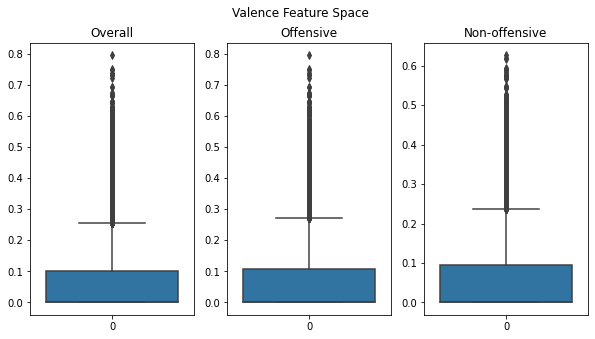

In [ ]:
positive_df = val_feature_df[master_df['Label'] == 1]
negative_df = val_feature_df[master_df['Label'] == 0]

fig, axes = plt.subplots(1,3,figsize=(10,5))
fig.suptitle("Valence Feature Space")
val_features = np.asarray(val_feature_df.stack())
sns.boxplot(data = val_features,ax=axes[0])
axes[0].set_title('Overall')
val_features = np.asarray(positive_df.stack())
sns.boxplot(data = val_features, ax=axes[1])
axes[1].set_title('Offensive')
val_features = np.asarray(negative_df.stack())
sns.boxplot(data = val_features, ax=axes[2])
axes[2].set_title('Non-offensive')

Text(0.5, 1.0, 'Non-offensive')

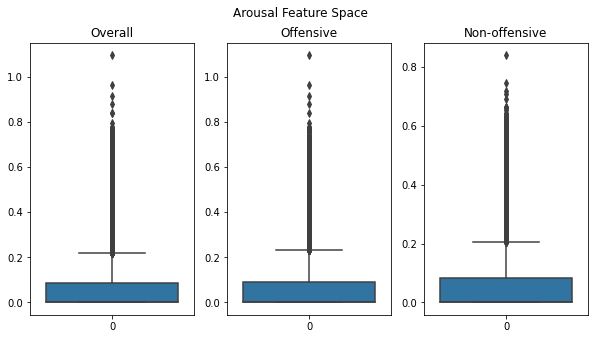

In [ ]:
positive_df = ars_feature_df[master_df['Label'] == 1]
negative_df = ars_feature_df[master_df['Label'] == 0]

fig, axes = plt.subplots(1,3,figsize=(10,5))
fig.suptitle("Arousal Feature Space")
ars_features = np.asarray(ars_feature_df.stack())
sns.boxplot(data = ars_features,ax=axes[0])
axes[0].set_title('Overall')
ars_features = np.asarray(positive_df.stack())
sns.boxplot(data = ars_features, ax=axes[1])
axes[1].set_title('Offensive')
ars_features = np.asarray(negative_df.stack())
sns.boxplot(data = ars_features, ax=axes[2])
axes[2].set_title('Non-offensive')

Text(0.5, 1.0, 'Non-offensive')

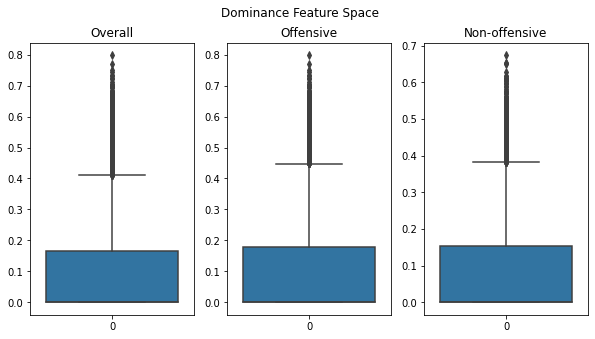

In [ ]:
positive_df = dom_feature_df[master_df['Label'] == 1]
negative_df = dom_feature_df[master_df['Label'] == 0]

fig, axes = plt.subplots(1,3,figsize=(10,5))
fig.suptitle("Dominance Feature Space")
dom_features = np.asarray(dom_feature_df.stack())
sns.boxplot(data = dom_features,ax=axes[0])
axes[0].set_title('Overall')
dom_features = np.asarray(positive_df.stack())
sns.boxplot(data = dom_features, ax=axes[1])
axes[1].set_title('Offensive')
dom_features = np.asarray(negative_df.stack())
sns.boxplot(data = dom_features, ax=axes[2])
axes[2].set_title('Non-offensive')

# Load Data

In [ ]:
features_master_df = pd.concat([master_df[['file_name', 'Label']], emotion_feature_df, text_feature_df], axis=1)
print(features_master_df.shape)

(499, 1280)


In [ ]:
y = master_df['Label']
ohe = OneHotEncoder()
ohe.fit(np.asarray(y).reshape(-1,1))
y_ohe = ohe.transform(np.asarray(y).reshape(-1,1)).toarray()

In [ ]:
X_train_df, X_temp_df, y_train, y_temp = train_test_split(features_master_df, y, test_size=0.2, shuffle=True, random_state=4, stratify=y)

X_test_df, X_val_df, y_test, y_val = train_test_split(X_temp_df, y_temp, test_size=0.5, shuffle=True, random_state=4, stratify=y_temp)

X_train = np.asarray(X_train_df.drop(columns=['file_name', 'Label']))
X_test = np.asarray(X_test_df.drop(columns=['file_name', 'Label']))
X_val = np.asarray(X_val_df.drop(columns=['file_name', 'Label']))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(399, 1278)
(50, 1278)
(50, 1278)
(399,)
(50,)
(50,)


# Train Model

In [ ]:
# Baseline text model performance
text_test_df = pd.merge(X_test_df[['file_name', 'Label']], master_df[['file_name', 'Text']], on='file_name')
(_, predictions) = get_text_embeddings(text_test_df['Text'])
report = classification_report(text_test_df['Label'], predictions, zero_division=0)
print(report)

In [ ]:
num_classes = 1
batch_size = 4
num_epochs = 100

In [ ]:
inputs = inputs = tf.keras.Input(shape=(X_test.shape[1],))
do_1 = Dropout(0.03)(inputs)
dense_1 = Dense(600, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(do_1) 
do_2 = Dropout(0.05)(dense_1)
dense_2 = Dense(300, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(do_2) 
do_3 = Dropout(0.01)(dense_2)
dense_3 = Dense(150, activation='relu', kernel_initializer= 'he_normal', kernel_regularizer=regularizers.l2(l=0.000000001))(do_3) 
output = Dense(num_classes, activation='sigmoid')(dense_3)
model = tf.keras.Model(inputs, output)

In [ ]:
if model is None:
  exit('Something went wrong!!')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.99)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
f1_score = F1Score(num_classes = num_classes)

model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy', f1_score])
print(model.summary())

In [ ]:
hist = model.fit(x=X_train, y=y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

In [ ]:
model.save(WORKSPACE+'/mml_model_5')

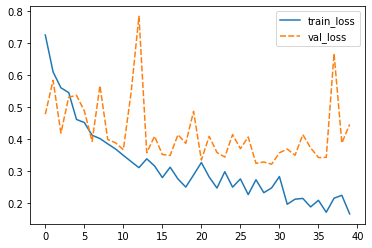

In [ ]:
loss_df = pd.DataFrame({"train_loss": hist.history['loss'], "val_loss":  hist.history['val_loss']})
sns.lineplot(data=loss_df)

# Model Evalutaion

In [ ]:
threshhold = 0.2
y_pred = model.predict(X_test)
y_pred = [1 if x > threshhold else 0 for x in y_pred]
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["non-offensive","offensive"]).plot()